# Trabalho T3: Question Answering (NLP-gym)

O objetivo deste trabaho é realizar o treino de um agente de Aprendizado por Reforço aplicado ao problema de Question Answering do environment NLP-gym, disponível em:

https://github.com/rajcscw/nlp-gym

O foco do trabalho é a escolha do algoritmo a ser utilizado, entre os disponíveis nas bibliotecas *keras-rl2* e *stable_baselines3*. Para maiores informações sobre escolha do algoritmo estudar aula 8:

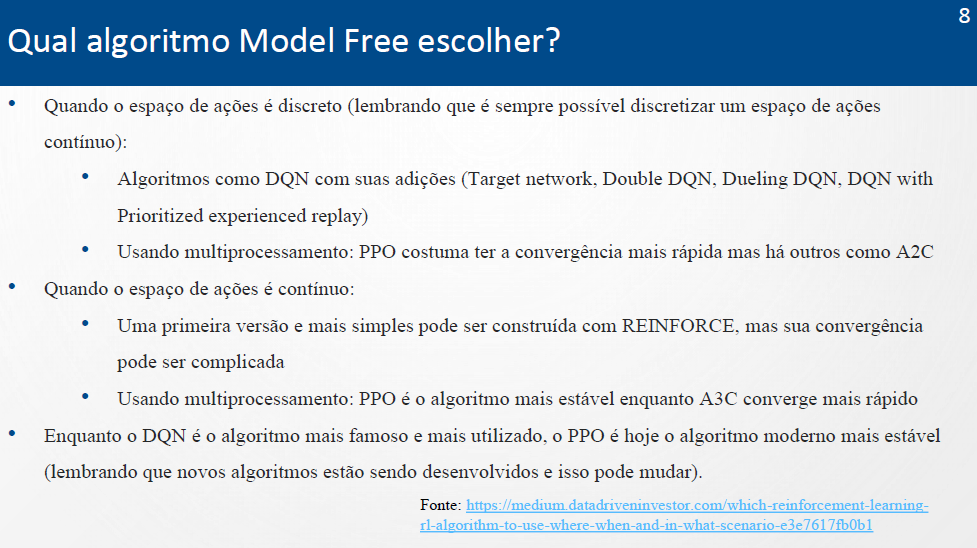

## Multiple-Choice Question Answering

O Aprendizado por Reforço tornou-se popular em diversas aplicações de Processamento de Linguagem Natural (NLP) devido à formulação direta de tarefas da área como problemas de tomada de decisão sequencial, nos quais recompensas são facilmente definidas e o Aprendizado por Reforço fornece resultados do estado da arte.

Neste trabalho vamos resolver um problema de **Multiple-Choice Question Answering**: A partir de uma pergunta $q$ e de um conjunto de fatos $f$, o agente deve responder com uma das alternativas $c_1,...,c_m$. A figura abaixo ilustra a interação entre agente e ambiente na aplicação de Question Answering.




## NLP-gym Environment

O ambiente utilizado neste trabalho é o NLP-gym, apresentado neste trabalho:

https://arxiv.org/pdf/2011.08272.pdf


Neste ambiente, o problema sequencial de Question Answering é implementado da segunte forma:

1) O agente recebe uma observação composta pela pergunta $q$ a ser respondida, um conjunto de fatos informativos $f$ e uma alternativa $c_i$ entre as possíveis (no total há até 8 alternativas para cada pergunta)

2) As observações são transformadas em estados por meio de um featurizer, que concatena a pergunta, os fatos e a alternativa em uma representação vetorial.

3) O agente recebe o estado e escolhe entre duas possíveis ações: 'CONTINUE' (1) e 'ANSWER' (0). Se a ação ANSWER for tomada o agente escolhe a alternativa $c_i$ como resposta para a pergunta, recebe uma recompensa $r=1$ no caso de acerto e $r=0$ no caso de erro. Se a ação CONTINUE for tomada o ambiente fornece a próxima alternativa $c_{i+1}$ para a mesma pergunta.


O principal objetivo é o treinamento de um agente capaz de entender como combinar os fatos $f$ de forma correta para responder a pergunta $q$.




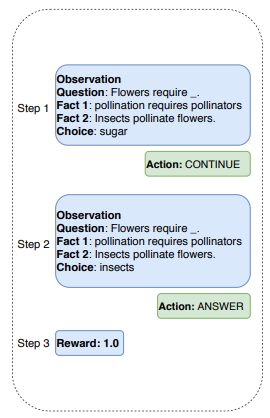

Vamos instalar o ambiente:

In [ ]:
!pip install nlp-gym

## Imports

In [ ]:
from nlp_gym.data_pools.custom_question_answering_pools import QASC
from nlp_gym.envs.question_answering.env import QAEnv
from nlp_gym.envs.question_answering.featurizer import InformedFeaturizer

## Dataset

O dataset utilizado para o treino e validação do agente é o QASC (https://arxiv.org/pdf/1910.11473.pdf), composto por um conjunto de 9980 perguntas de múltipla-escolha, com as respectivas alternativas e fatos relevantes para a resposta.

O QASC é utilizado como um dataset de benchmarking em diversos problemas nos quais um agente deve ser capaz de raciocinar sobre os fatos para obter as respostas, trata-se de um problema desafiador e por isso precisões altas são raras. Neste trabalho o objetivo é alcançar aproximadamente 40-50% de respostas corretas no dataset de teste, o que é um ótimo resultado dada a dimensão da rede neural implementada.

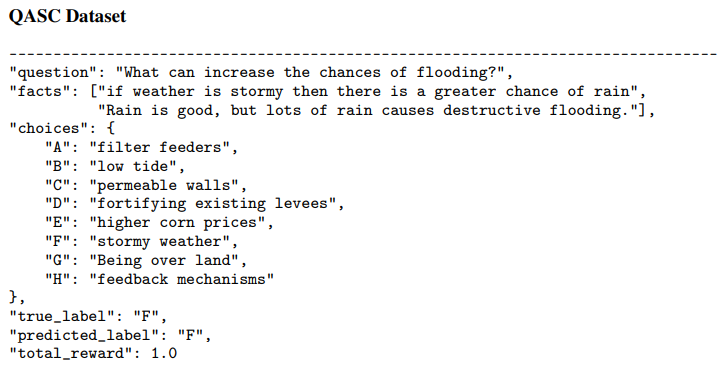

### Training and Validation Data

In [ ]:
# Training
data_pool = QASC.prepare(split="train")
# Validation
val_pool = QASC.prepare(split="val")

## Create QAEnv environment

Vamos criar dois ambientes, um para o treino e outro para validação do agente, compostos pelos respectivos datasets.

Em primeiro lugar é preciso criar o *featurizer* utilizado para transformar observações do ambiente em representações vetoriais de estados utilizadas pelo agente.

In [ ]:
# featurizer
featurizer = InformedFeaturizer()

# QA Training Environment
env = QAEnv(observation_featurizer=featurizer)
for sample, weight in data_pool:
    env.add_sample(sample, weight)

# QA Validation Environment
eval_env = QAEnv(observation_featurizer=featurizer)# question answering env
for sample, weight in val_pool:
    eval_env.add_sample(sample, weight)



## Download e Import das bibliotecas stable_baselines3 e keras-rl2


In [ ]:
!pip install stable_baselines3
!pip install keras-rl2

## Funções Auxiliares de Validação

### Stable Baselines 3

Função de avaliação de agente treinado da biblioteca stable_baselines3

In [ ]:
def eval_stable_baselines(eval_env, stable_baselines_agent, val_pool):
    correctly_answered = 0.0
    for sample, _ in val_pool:
        obs = eval_env.reset(sample)
        state = None
        done = False
        while not done:
            action, state = stable_baselines_agent.predict(obs)
            obs, reward, done, info = eval_env.step(int(action))

        if info["selected_choice"] == sample.answer:
            correctly_answered += 1

    return correctly_answered/len(val_pool)


### Keras-rl 2

Função de avaliação de agente treinado da biblioteca keras-rl2

In [ ]:
def eval_kerasrl(agent, eval_env):
    # Number of episodes to validate the agent
    nb_episodes = 1000
    test_history = agent.test(eval_env, nb_episodes=nb_episodes, visualize=False)
    # Accuracy = sum(rewards)/nb_episodes
    return (sum(test_history.history['episode_reward'])/nb_episodes)

## Tarefa a) Criação e treino de agente

In [ ]:
# Escreva aqui seu código

## Tarefa b) Avaliação de agente treinado

Avalie o desempenho do agente treinado por meio de uma das funções auxiliares acima:


*   Stable Baselines 3 -> **eval_stable_baselines(eval_env, stable_baselines_agent, val_pool)**
*   Keras-rl 2 -> **eval_kerasrl(agent, eval_env)**



In [ ]:
# Escreva aqui seu código

## Recomendações

Para este trabalho pode-se escolher qualquer algoritmo de RL estudado no curso que seja compatível com a aplicação. Nos nossos testes esses apresentaram bons resultados:

*   Keras-rl 2: DQN

    *   Arquitetura da rede: MLP 3 hidden layers de 16 neurônios com funções de ativação ReLu
    *   gamma = 0.99
    *   policy = BoltzmannQPolicy()
    *   optimizer = Adam (lr=1e-3, metrics=['mae'])
    *   nb_steps = 50000


*   Stable Baselines 3: PPO

    *   MLP padrão
    *   gamma = 0.99
    *   learning_rate = 0.001
    *   total_timesteps = 50000

*   Stable Baselines 3: DQN

    *   MLP padrão
    *   gamma = 0.99
    *   learning_rate = 1e-3
    *   total_timesteps = 50000




Para consulta sugerimos estudar os códigos da aula 5:

*   keras_rl_cartpole_DQN.ipynb 
*   keras_rl_cartpole_Dueling_DQN.ipynb
*   keras_rl_cartpole_Double_DQN.ipynb

e da aula 6:

*   PPO_cartpole_v1.ipynb

e as documentações das duas bibliotecas:

https://stable-baselines3.readthedocs.io/en/master/index.html

https://github.com/wau/keras-rl2

